In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.functional import F
from torch import optim

In [2]:
dframe = pandas.read_csv("stock_prices_apple_last_year.csv", engine='python')

In [3]:
frame = dframe.drop('Date', 1)

In [4]:
frame

,Close/Last,Volume,Open,High,Low
0,$241.41,32470020,$242.8,$245.7,$238.9741
1,$244.93,41483490,$240.34,$245.15,$236.9
2,$240.91,44054640,$246.5,$248.72,$239.13
3,$254.29,49250500,$255.6,$262.49,$252
4,$254.81,41994110,$250.74,$255.52,$249.4
...,...,...,...,...,...
247,$198.95,20543190,$200.85,$201,$198.4431
248,$200.62,21654750,$198.68,$200.74,$198.18
249,$199.5,35738280,$200.32,$202.85,$199.23
250,$200.1,25829880,$196.42,$200.23,$196.34


In [5]:
np_frame = frame.to_numpy()

In [6]:
for i in range(len(np_frame)):
    for j in range(len(np_frame[0])):
        if type(np_frame[i][j]) is int:
            pass
        else:
            np_frame[i][j] = ''.join( np_frame[i][j].split() ).strip("$")

In [7]:
dataframe = pandas.DataFrame(np_frame)
dataframe.columns = ["Close/Last", "Volume", "Open", "High", "Low"]

In [8]:
#
dataset = dataframe.values.astype("float32")

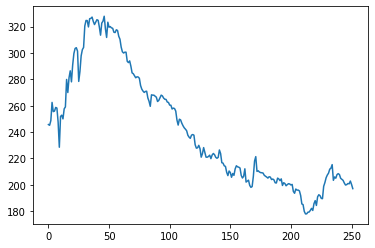

In [9]:
# график максимальных за день цен (прошедший год) 
plt.plot(dataset[:, 3])
plt.show()

In [10]:
# мы же должны подавать модели стандартизованные данные, так что
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [11]:
dataset

array([[0.44256008, 0.22135231, 0.45117223, 0.45207763, 0.44881177],
       [0.46543205, 0.3158736 , 0.43469524, 0.4484092 , 0.43526256],
       [0.43931127, 0.3428364 , 0.47595453, 0.47222042, 0.44983017],
       ...,
       [0.1702404 , 0.2556255 , 0.16664433, 0.16627765, 0.18918204],
       [0.17413902, 0.15171936, 0.14052236, 0.14880276, 0.17030299],
       [0.15399611, 0.07457092, 0.14072335, 0.12792647, 0.16762471]],
      dtype=float32)

In [12]:
# пусть 68% всех точек будет тренировочным сетом, оставшиеся 32 тестовым
train_size = int(len(dataset) * 0.68)
test_size = len(dataset) - train_size

In [13]:
train_size, test_size

(171, 81)

In [14]:
train = dataset[0:train_size]
test = dataset[train_size:]

In [15]:
# самое важное во всей процедуре 

def create_dataset(ds, look_back=1):
    x, y = [], []
    
    for i in range(len(ds) - 1 - look_back):
        x.append(ds[i : (i + look_back)])
        y.append(ds[i + look_back])
        
    return np.array(x), np.array(y)

In [16]:
shifted_dataset = create_dataset(dataset)

In [17]:
x_train, y_train = create_dataset(train)
x_test, y_test = create_dataset(test)

In [20]:
x_train.shape

(169, 1, 5)

In [21]:
x_test.shape

(79, 1, 5)

In [30]:

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.lstm = nn.LSTM(input_size=1, hidden_size=4)
        self.classifier = nn.Linear(4, 1)
        
    def forward(self, x):
        x = F.tanh(self.lstm(x))
        x = self.classifier(x)
        
        return x
    
class Net2(nn.Module):
    
    
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super(Net2, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        
        self.hidden_cell = (torch.zeros(1, 1, hidden_size),
                            torch.zeros(1, 1, hidden_size))
        
    def forward(self, seq):
        lstm_out, self.hidden_cell = self.lstm(seq.view(len(seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(seq), -1))
        
        return predictions

In [31]:
net = Net2()

In [32]:

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [34]:
net

Net2(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [46]:
n_epoches = 100

for i in range(n_epoches):
    for seq, labels in [(x_train, y_train)]:
        optimizer.zero_grad()
        
        net.hidden_cell = (torch.zeros(1, 1, net.hidden_size),
                           torch.zeros(1, 1, net.hidden_size))

        seq = torch.Tensor(seq).view(-1)
        y_pred = net(seq)
        
        loss = criterion(seq, y_pred)
        loss.backward()
        
        optimizer.step()
        
    if i % 10 == 0:
        print("loss is {}".format(loss.item()))
        

loss is 0.07463295757770538
loss is 0.07656742632389069
loss is 0.07481183856725693
loss is 0.07412195950746536
loss is 0.07386946678161621
loss is 0.07376253604888916
loss is 0.07371485233306885
loss is 0.0736948549747467
loss is 0.07368720322847366
loss is 0.07368364930152893


In [47]:
net.eval()

Net2(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [48]:
listed_test = x_test.tolist()

In [53]:
feat_steps = 1

out = []

for i in range(feat_steps):
    seq = torch.FloatTensor(listed_test[-1:])
    
    with torch.no_grad():
        net.hidden = (torch.zeros(1, 1, net.hidden_size),
                        torch.zeros(1, 1, net.hidden_size))
        out.append(net(seq).view(-1).item() )

RuntimeError: input.size(-1) must be equal to input_size. Expected 1, got 5